In [1]:
from argparse import ArgumentParser
import numpy as np
import ipdb
import sklearn.metrics as metrics

import torch
# from cmehr.dataset.mimic4_downstream_datamodule import MIMIC4DataModule
from cmehr.dataset.mimic3_downstream_datamodule import MIMIC3DataModule
from tqdm import tqdm
# from cmehr.models.mimic4 import (POCMPModule)
from cmehr.models.mimic3.pocmp_model import POCMPModule
from cmehr.paths import *

/home/fywang/miniconda3/envs/ehr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# args.orig_d_ts = 17
# args.orig_reg_d_ts = 34

# # define datamodule
# if args.first_nrows == -1:
#     args.first_nrows = None

# if args.task == "ihm":
#     args.period_length = 48
# elif args.task == "pheno":
#     args.period_length = 24
task = "pheno"
period_length = 24
batch_size = 16
num_workers = 4
first_nrows = -1
ckpt_path = "/home/fywang/Documents/MMMSPG/log/ckpts/mimic3_pheno_pocmp_2024-10-10_16-10-31/epoch=26-step=5373.ckpt"

model = POCMPModule.load_from_checkpoint(ckpt_path, map_location=torch.device("cuda:0"), strict=False)
model.eval()
dm = MIMIC3DataModule(
        file_path=str(
            DATA_PATH / f"output_mimic3/{task}"),
        tt_max=period_length,
        batch_size=batch_size,
        modeltype="TS_Text",
        num_workers=num_workers,
        first_nrows=first_nrows)

/home/fywang/miniconda3/envs/ehr/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/fywang/miniconda3/envs/ehr/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/fywang/miniconda3/envs/ehr/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['ts_sl

In [3]:
for batch in dm.test_dataloader():
    break

for k, v in batch.items():
    print(f"{k}: ", v.shape)

Number of original samples:  5012
Number of filtered samples in test set: 5001
ts:  torch.Size([16, 60, 17])
ts_mask:  torch.Size([16, 60, 17])
ts_tt:  torch.Size([16, 60])
reg_ts:  torch.Size([16, 24, 34])
input_ids:  torch.Size([16, 5, 512])
attention_mask:  torch.Size([16, 5, 512])
note_time:  torch.Size([16, 5])
note_time_mask:  torch.Size([16, 5])
label:  torch.Size([16, 25])


In [4]:
import torch.nn.functional as F
import torch.nn as nn
import torch
from einops import rearrange

device = torch.device("cuda:0")

with torch.no_grad():
    x_ts = batch["ts"].to(device)
    x_ts_mask = batch["ts_mask"].to(device)
    ts_tt_list = batch["ts_tt"].to(device)
    reg_ts = batch["reg_ts"].to(device)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    note_time = batch["note_time"].to(device)
    note_time_mask = batch["note_time_mask"].to(device)

    # STEP 1: extract embeddings from irregular data.
    proj_x_ts_irg = model.forward_ts_mtand(
        x_ts, x_ts_mask, ts_tt_list)
    proj_x_ts_reg = model.forward_ts_reg(reg_ts)
    proj_x_ts = model.gate_ts(proj_x_ts_irg, proj_x_ts_reg)
    proj_x_ts = rearrange(proj_x_ts, "tt b d -> b d tt")
    proj_x_text_irg = model.forward_text_mtand(
        input_ids, attention_mask, note_time, note_time_mask)
    proj_x_text = rearrange(proj_x_text_irg, "tt b d -> b d tt")

    # STEP 2: multi-scale features
    ts_emb_1 = model.ts_conv_1(proj_x_ts)
    ts_emb_2 = F.avg_pool1d(ts_emb_1, 2)
    ts_emb_2 = model.ts_conv_2(ts_emb_2)
    ts_emb_3 = F.avg_pool1d(ts_emb_2, 2)
    ts_emb_3 = model.ts_conv_3(ts_emb_3)

    # STEP 3: extract prototypes from the multi-scale features
    ts_feat_list = []
    if not model.use_multiscale:
        # if we don't use multiscale, we only use the first layer
        ts_feat = ts_emb_1
        ts_feat = rearrange(ts_feat, "b d tt -> b tt d")
        ts_feat_list.append(ts_feat)
    else:
        for idx, ts_feat in enumerate([ts_emb_1, ts_emb_2, ts_emb_3]):
            # extract the feature in each window
            ts_feat = rearrange(ts_feat, "b d tt -> b tt d")
            ts_feat_list.append(ts_feat)

    # STEP 4: extract prototype features from notes 
    # Only consider one scale for image.
    text_emb = model.text_conv_1(proj_x_text)
    text_feat = rearrange(text_emb, "b d tt -> b tt d")
    text_feat_list = []
    text_feat_list.append(text_feat)

    ts_feat_concat = torch.cat(ts_feat_list, dim=1)
    text_feat_concat = torch.cat(text_feat_list, dim=1)
    
    cont_loss = torch.tensor(0.).type_as(x_ts)
    # recon_loss = torch.tensor(0.).type_as(x_ts)
    ts_recon_loss = torch.tensor(0.).type_as(x_ts)
    text_recon_loss = torch.tensor(0.).type_as(x_ts)
    if model.use_prototype:
        batch_size = x_ts.size(0)
        shared_mu = model.shared_slots_mu.expand(batch_size, model.num_slots, -1)
        shared_sigma = model.shared_slots_logsigma.exp().expand(batch_size, model.num_slots, -1)
        shared_slots = shared_mu + shared_sigma * torch.randn(shared_mu.shape).type_as(x_ts)
        # ts_mu = model.ts_slots_mu.expand(batch_size, model.num_slots, -1)
        # ts_sigma = model.ts_slots_logsigma.exp().expand(batch_size, model.num_slots, -1)
        # ts_slots = ts_mu + ts_sigma * torch.randn(ts_mu.shape).type_as(x_ts)
        # text_mu = model.text_slots_mu.expand(batch_size, model.num_slots, -1)
        # text_sigma = model.text_slots_logsigma.exp().expand(batch_size, model.num_slots, -1)
        # text_slots = text_mu + text_sigma * torch.randn(text_mu.shape).type_as(x_ts)

        pe = model.pe(ts_feat_concat)
        ts_pe = ts_feat_concat + pe
        shared_ts_slots, ts_attn = model.ts_grouping(shared_slots, ts_pe)
        shared_ts_slots = F.normalize(shared_ts_slots, dim=-1)
        # ts_slots = model.ts_grouping(ts_slots, ts_pe)
        # ts_slots = F.normalize(ts_slots, dim=-1)
        
        pe = model.pe(text_feat_concat)
        text_pe = text_feat_concat + pe
        shared_text_slots, text_attn = model.text_grouping(shared_slots, text_pe)
        shared_text_slots = F.normalize(shared_text_slots, dim=-1)
        # text_slots = model.text_grouping(text_slots, text_pe)
        # text_slots = F.normalize(text_slots, dim=-1)

        # compute contrastive loss
        global_ts_feat = shared_ts_slots.mean(dim=1)
        global_text_feat = shared_text_slots.mean(dim=1)
        global_feat = torch.cat([global_ts_feat, global_text_feat], dim=1)
        slot_weights = F.softmax(model.weight_proj(global_feat), dim=-1)
        pair_similarity = torch.einsum('bnd,cnd->bcn', shared_ts_slots, shared_text_slots)
        similarity = torch.einsum('bcn,bn->bc', pair_similarity, slot_weights)
        cont_loss = model.infonce_loss(similarity, temperature=0.2)

        # concat_ts_slot = torch.cat([shared_ts_slots, ts_slots], dim=1)
        concat_ts_slot = shared_ts_slots
        concat_ts_feat = torch.cat(ts_feat_list, dim=1)
        # concat_text_slot = torch.cat([shared_text_slots, text_slots], dim=1)
        concat_text_slot = shared_text_slots
        concat_text_feat = torch.cat(text_feat_list, dim=1)
        # both slots and timestamp-level embeddings are used
        concat_feat = torch.cat([concat_ts_slot, concat_ts_feat,
                                    concat_text_slot, concat_text_feat], dim=1)
        # concat_feat = torch.cat([concat_ts_slot, concat_text_slot], dim=1)

        # using predicted slot features to reconstruct regular time series
        ts_tgt_embs = rearrange(proj_x_ts_reg, "tt b d -> b tt d")
        mask = nn.Transformer.generate_square_subsequent_mask(model.tt_max - 1)
        pred_ts_emb = model.ts_decoder(tgt=ts_tgt_embs[:, :-1], memory=concat_ts_slot, tgt_mask=mask, tgt_is_causal=True)
        pred_ts = model.ts_proj(pred_ts_emb)
        ts_recon_loss = F.mse_loss(pred_ts, reg_ts[:, 1:])

        text_tgt_embs = rearrange(proj_x_text_irg, "tt b d -> b tt d")
        pred_text_emb = model.text_decoder(tgt=text_tgt_embs[:, :-1], memory=concat_text_slot, tgt_mask=mask, tgt_is_causal=True)
        text_recon_loss = F.mse_loss(pred_text_emb, text_tgt_embs[:, 1:])
    else:
        concat_ts_feat = torch.cat(ts_feat_list, dim=1)
        concat_text_feat = torch.cat(text_feat_list, dim=1)
        concat_feat = torch.cat([concat_ts_feat, concat_text_feat], dim=1)

    fusion_feat = model.fusion_layer(concat_feat)

    # STEP 7: make prediction
    if model.use_prototype:
        num_ts_tokens = concat_ts_slot.size(1) + concat_ts_feat.size(1)
        # num_ts_tokens = concat_ts_slot.size(1)
    else:
        num_ts_tokens = concat_ts_feat.size(1)
    
    # num_text_tokens = concat_text_slot.size(1) + concat_text_feat.size(1)
    # ts_pred_tokens = fusion_feat[:, :num_ts_tokens, :]
    # attn, ts_pred_tokens = model.ts_atten_pooling(ts_pred_tokens)
    # last_ts_feat = torch.bmm(attn.permute(0, 2, 1), ts_pred_tokens).squeeze(dim=1)
    # text_pred_tokens = fusion_feat[:, num_ts_tokens:, :]
    # attn, text_pred_tokens = model.text_atten_pooling(text_pred_tokens)
    # last_text_feat = torch.bmm(attn.permute(0, 2, 1), text_pred_tokens).squeeze(dim=1)
    last_ts_feat = torch.mean(fusion_feat[:, :num_ts_tokens, :], dim=1)
    last_text_feat = torch.mean(fusion_feat[:, num_ts_tokens:, :], dim=1)
    last_hs = torch.cat([last_ts_feat, last_text_feat], dim=1)

    output = model.out_layer(last_hs)

In [5]:
ts_attn.shape

torch.Size([16, 16, 42])

In [6]:
ts_attn[0].shape

torch.Size([16, 42])

In [7]:
text_attn[0]

tensor([[0.0282, 0.0271, 0.0294, 0.0316, 0.0337, 0.0361, 0.0404, 0.0478, 0.0569,
         0.0626, 0.0614, 0.0558, 0.0508, 0.0490, 0.0491, 0.0482, 0.0451, 0.0408,
         0.0368, 0.0343, 0.0338, 0.0347, 0.0346, 0.0317],
        [0.0260, 0.0220, 0.0227, 0.0259, 0.0298, 0.0329, 0.0356, 0.0406, 0.0503,
         0.0649, 0.0799, 0.0871, 0.0825, 0.0698, 0.0551, 0.0427, 0.0339, 0.0283,
         0.0246, 0.0227, 0.0231, 0.0264, 0.0321, 0.0411],
        [0.0255, 0.0251, 0.0259, 0.0269, 0.0297, 0.0350, 0.0423, 0.0488, 0.0497,
         0.0437, 0.0353, 0.0300, 0.0302, 0.0370, 0.0513, 0.0702, 0.0846, 0.0833,
         0.0662, 0.0457, 0.0319, 0.0262, 0.0261, 0.0294],
        [0.0396, 0.0402, 0.0376, 0.0335, 0.0291, 0.0261, 0.0255, 0.0269, 0.0292,
         0.0313, 0.0332, 0.0367, 0.0432, 0.0514, 0.0565, 0.0544, 0.0485, 0.0443,
         0.0445, 0.0486, 0.0543, 0.0583, 0.0564, 0.0505],
        [0.0261, 0.0261, 0.0245, 0.0243, 0.0266, 0.0312, 0.0353, 0.0346, 0.0279,
         0.0198, 0.0148, 0.0140, 0.0181

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

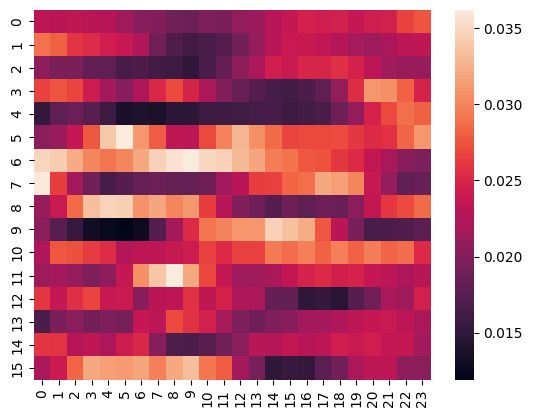

In [9]:
sns.heatmap(ts_attn[0].cpu().numpy()[:, :24])

<Axes: >

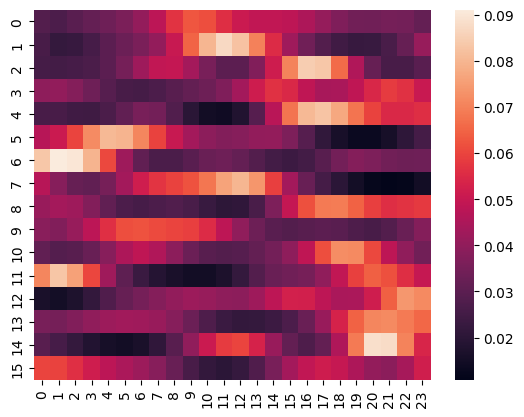

In [10]:
# plt.plot(reg_ts[0].cpu().numpy().T)
sns.heatmap(text_attn[0].cpu().numpy())

In [11]:
np.var(reg_ts[0].cpu().numpy().T[:17], axis=1)

array([5.5511151e-17, 6.6580549e-03, 7.9936058e-15, 3.6817613e-01,
       7.1146113e-01, 1.0986041e+00, 9.2265248e-01, 2.6959514e-02,
       1.3048361e-01, 5.5511151e-17, 1.4420449e-02, 1.1315216e-06,
       4.8684588e-01, 1.3545544e-02, 4.5647353e-02, 5.7668955e-04,
       2.8624540e-04], dtype=float32)

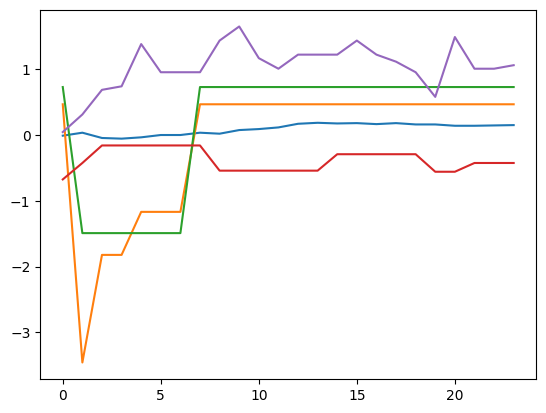

In [12]:
plt.plot(reg_ts[0].cpu().numpy()[:, [1,5,6, 7, 8]])

In [13]:
input_ids.shape

torch.Size([16, 5, 512])

In [14]:
# tokenizer = dm.tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
tokenizer.batch_decode(input_ids[0], skip_special_tokens=True)

['5 : 22 am ankle ( 2 views ) bilat ; tib / fib ( ap & lat ) bilat clip # reason : assess for fx admitting diagnosis : s / p fall medical condition : 19 year old woman s / p fall reason for this examination : assess for fx final report right lower leg and right ankle, three views left lower leg and left ankle, three views indication : status post fall. findings : right lower leg and right foot, no comparisons : no acute fracture or dislocation is seen. comminuted fracture at the base of the 4th metatarsal is not well evaluated on the current study. the ankle mortise is symmetric and the talar dome is intact. there is lateral malleolar soft tissue swelling. only a frontal radiograph of the right lower leg has been performed ; no fracture is identified on this single frontal radiograph. the soft tissues are otherwise unremarkable. left lower leg and left ankle, no comparisons : there is a comminuted fracture of the left calcaneus with extension of the fracture line into the subtalar join

In [15]:
note_time * 24

tensor([[ 0.4833,  5.5333,  8.3167, 12.9333,  0.0000],
        [ 6.9667,  8.1667,  9.9167, 19.2833, 20.3167],
        [ 3.2000,  3.3833, 12.2333, 15.4500,  0.0000],
        [ 5.2333,  8.2167, 17.1000, 17.6167, 23.1000],
        [ 7.2167, 11.1000, 19.7000, 22.9833,  0.0000],
        [ 2.1167,  9.7333, 11.7833,  0.0000,  0.0000],
        [ 0.7333,  6.1167,  6.4833, 19.7667,  0.0000],
        [ 6.7333,  9.3333, 11.4500, 23.6167,  0.0000],
        [ 3.2833,  3.3000, 11.4167, 19.7833, 23.1833],
        [ 5.1167,  7.4500, 15.4667, 16.4667,  0.0000],
        [ 0.5167,  3.9500,  8.7833, 12.9167,  0.0000],
        [ 8.4167, 10.6000, 22.3333,  0.0000,  0.0000],
        [20.5667,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 8.6667,  9.8000, 22.4667,  0.0000,  0.0000],
        [ 0.9667, 16.0833,  0.0000,  0.0000,  0.0000]], device='cuda:0')

In [16]:
import json
file_path = "/home/fywang/Documents/MMMSPG/src/cmehr/preprocess/mimic3/mimic3models/resources/discretizer_config.json"
with open(file_path, "r") as f:
    discretizer_config = json.load(f)

variables = discretizer_config["id_to_channel"]
print(variables)

['Capillary refill rate', 'Diastolic blood pressure', 'Fraction inspired oxygen', 'Glascow coma scale eye opening', 'Glascow coma scale motor response', 'Glascow coma scale total', 'Glascow coma scale verbal response', 'Glucose', 'Heart Rate', 'Height', 'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate', 'Systolic blood pressure', 'Temperature', 'Weight', 'pH']


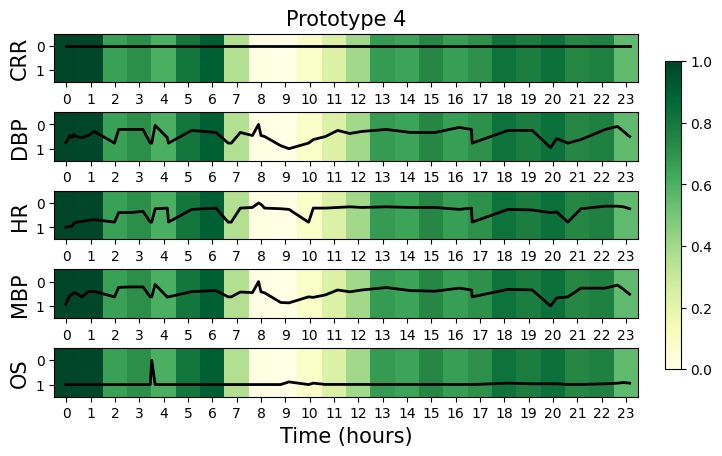

In [214]:
import matplotlib as mpl 


idx = 3
# prototype_idx = 0
ts_atten_matrix = ts_attn[0].cpu().numpy()[:, :24]
columns = [
    "CRR", "DBP", "HR", "MBP", "OS"
]
ts_tt_list = batch["ts_tt"].cpu().numpy()
x_ts = batch["ts"].cpu().numpy()
mask = ts_tt_list[idx] != 0
feature_indices = [0, 1, 8, 10, 11]
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 1)
fig.set_figwidth(8)
fig.set_figheight(4)
# 1, 5, 6, 14
# for c_i, prototype_idx in enumerate([1, 5]):
# for c_i, prototype_idx in enumerate([6, 14]):
prototype_idx = 14
for r_i, i in enumerate(feature_indices):
    # axes[r_i].imshow(ts_atten_matrix, aspect="auto")
    proto_0_matrix = ts_atten_matrix[prototype_idx].reshape(1, -1).repeat(2, axis=0)
    norm_proto_0_matrix = (proto_0_matrix - proto_0_matrix.min()) / (proto_0_matrix.max() - proto_0_matrix.min())
    # sns.heatmap(norm_proto_0_matrix, cmap="YlGn", vmin=0, vmax=1, ax=axes[r_i], cbar=False)
    im = axes[r_i].imshow(norm_proto_0_matrix, cmap="YlGn", vmin=0, vmax=1)

    ts_min = x_ts[idx][mask, i].min()
    ts_max = x_ts[idx][mask, i].max()
    ts_range = ts_max - ts_min + 1e-6
    axes[r_i].plot(ts_tt_list[idx][mask] * 24 - 0.5, (x_ts[idx][mask, i] - ts_min) / ts_range, 
                linewidth=2,
                color="black")
    axes[r_i].set_xticks(np.arange(24))
    axes[r_i].set_xticklabels(np.arange(0, 24))
    # axes[r_i].set_axis_off()
    # break
    # axes[r_i].plot(ts_tt_list[idx][mask] * 24, x_ts[idx][mask, i], color="black")
    # # axes[r_i].grid()
    axes[r_i].set_ylabel(columns[r_i], fontsize=15)
    # axes[r_i].get_yaxis().set_label_coords(-0.06, 0.5)
    # axes[r_i].set_xlim(0, 24)
    # # plt.axis('off')
    # axes[r_i].set_axis_off()
    # print(variables[i])

    axes[4].set_xlabel("Time (hours)", fontsize=15)
    axes[0].set_title(f"Prototype 4", fontsize=15)

    # cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    # plt.colorbar(im, cax=cax, **kw)
fig.colorbar(im, ax=axes)
        # if r_i == 4:
        #     fig.colorbar(im, ax=axes[r_i][c_i])

# 
# plt.tight_layout()
plt.subplots_adjust(
    top=0.97, bottom=0.02, left=0.02,
    right=0.75,
    # wspace=0.5, 
    hspace=0.2
    )
plt.savefig("ts_atten_4.pdf", format="pdf", bbox_inches="tight")

# xmin, xmax = 1, 2
# import matplotlib
# trans = matplotlib.transforms.blended_transform_factory(axes[0].transData, fig.transFigure)
# r = matplotlib.patches.Rectangle(xy=(xmin,0), width=xmax-xmin, height=1, transform=trans,
#                                  fc='none', ec='r', lw=2)
# fig.add_artist(r)

# xmin, xmax = 8, 9
# trans = matplotlib.transforms.blended_transform_factory(
#     axes[0].transData, fig.transFigure)
# r = matplotlib.patches.Rectangle(xy=(xmin, 0), width=xmax-xmin, height=1, transform=trans,
#                                  fc='none', ec='r', lw=2)
# fig.add_artist(r)


# xmin, xmax = 12, 13
# trans = matplotlib.transforms.blended_transform_factory(
#     axes[0].transData, fig.transFigure)
# r = matplotlib.patches.Rectangle(xy=(xmin, 0), width=xmax-xmin, height=1, transform=trans,
#                                  fc='none', ec='r', lw=2)
# fig.add_artist(r)

# xmin, xmax = 20, 21
# trans = matplotlib.transforms.blended_transform_factory(
#     axes[0].transData, fig.transFigure)
# r = matplotlib.patches.Rectangle(xy=(xmin, 0), width=xmax-xmin, height=1, transform=trans,
#                                  fc='none', ec='r', lw=2)
# fig.add_artist(r)
# fig.savefig("case_study_1.pdf", format="pdf", bbox_inches="tight")

# from matplotlib.patches import Rectangle
# plt.gca().add_patch(Rectangle((25, 50),15,15,fill=True, color='g', alpha=0.5, zorder=100, figure=fig))

In [127]:
axes[:, c_i]

array([<Axes: ylabel='CRR'>, <Axes: ylabel='DBP'>, <Axes: ylabel='HR'>,
       <Axes: ylabel='MBP'>, <Axes: xlabel='Time (hours)', ylabel='OS'>],
      dtype=object)

<Axes: >

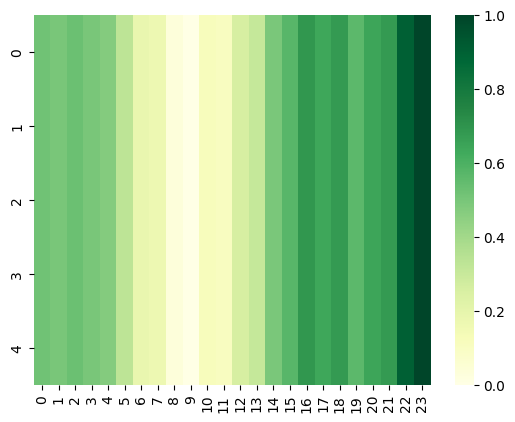

In [42]:
proto_0_matrix = ts_atten_matrix[0].reshape(1, -1).repeat(5, axis=0)
norm_proto_0_matrix = (proto_0_matrix - proto_0_matrix.min()) / (proto_0_matrix.max() - proto_0_matrix.min())
sns.heatmap(norm_proto_0_matrix, cmap="YlGn", vmin=0, vmax=1)

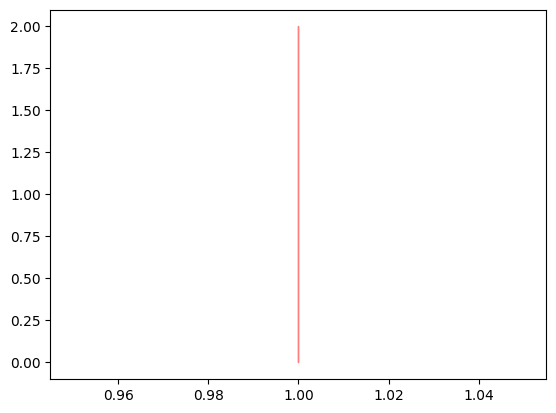

In [31]:
fig, ax = plt.subplots(1, 1)
ax.fill_between(1, [1, 2], color="red", alpha=0.5)

In [26]:
ts_atten_matrix.shape

(16, 24)

In [28]:
ts_atten_matrix[0]

array([0.02318305, 0.02303095, 0.0233071 , 0.02302354, 0.02277679,
       0.0215112 , 0.02024897, 0.02005662, 0.01886821, 0.01857998,
       0.01965561, 0.01954792, 0.02086977, 0.02130738, 0.02300042,
       0.0236856 , 0.02471215, 0.02427421, 0.02460577, 0.02359642,
       0.02430535, 0.02461365, 0.02662043, 0.02749608], dtype=float32)

In [29]:
ts_atten_matrix[1]

array([0.02894301, 0.02810651, 0.02588634, 0.0253745 , 0.02427247,
       0.02380157, 0.02243761, 0.01899857, 0.01690273, 0.01612777,
       0.01659041, 0.01738559, 0.01887946, 0.02106985, 0.02298801,
       0.02388933, 0.02381362, 0.02343565, 0.02274316, 0.02190283,
       0.02139754, 0.02226925, 0.02328346, 0.02332028], dtype=float32)

/tmp/ipykernel_1071983/4120850099.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(multi_attn[idx][:, cur_i], palette="husl",
/tmp/ipykernel_1071983/4120850099.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(1, 17), fontsize=14)
/tmp/ipykernel_1071983/4120850099.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(multi_attn[idx][:, cur_i], palette="husl",
/tmp/ipykernel_1071983/4120850099.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(1, 17), fontsize=14)
/tmp/ipykernel_1071983/4120850099.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is

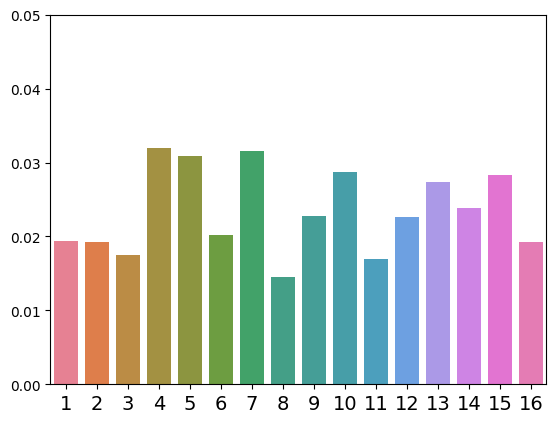

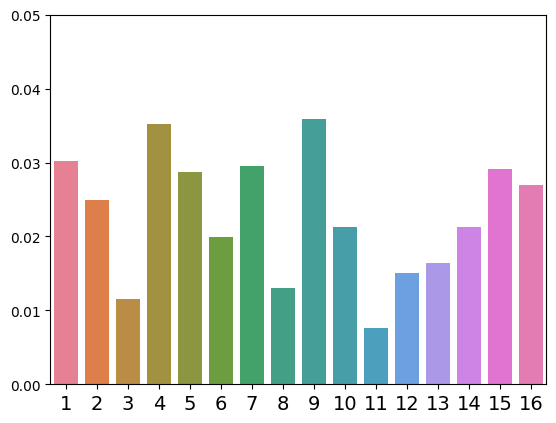

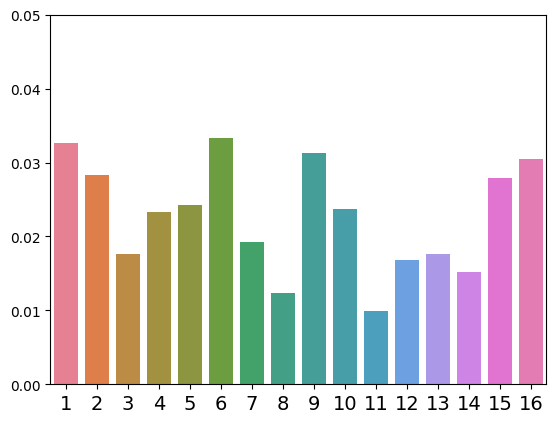

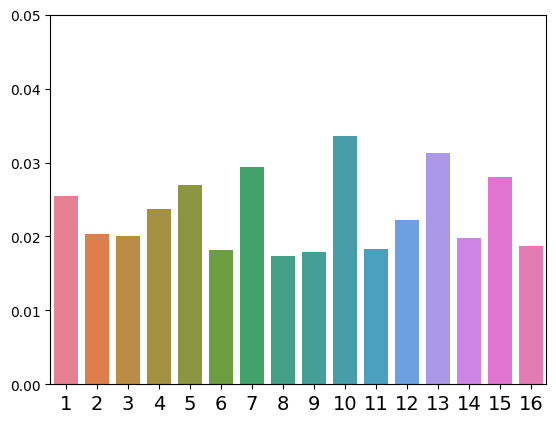

In [ ]:
idxs = [1, 8, 12, 20]
import numpy as np

import seaborn as sns

multi_attn = ts_attn.cpu().numpy()[:, :, :24]
# sns.heatmap()
for cur_i in idxs:
    fig, ax = plt.subplots(1, 1)
    sns.barplot(multi_attn[idx][:, cur_i], palette="husl", 
                ax=ax)
    ax.set_xticklabels(np.arange(1, 17), fontsize=14)
    ax.set_ylim(0, 0.05)